In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [8]:
class LayerCAM(object):

    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        if torch.cuda.is_available():
          self.model.cuda()
        self.gradients = []
        self.activations = []

        def backward_hook(module, grad_in, grad_out):
            def hook(grad):
                self.gradients.append(grad_out[0].detach())
            grad_out.register_hook(hook)
            

        def forward_hook(module, input, output):
            self.activations.append(output)

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_forward_hook(backward_hook)


    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
        else:
            predicted_class = torch.LongTensor([class_idx])
        
        one_hot_output = torch.FloatTensor(1, logit.size()[-1]).zero_()
        one_hot_output[0][predicted_class] = 1
        # Zero grads
        self.model.zero_grad()
        # Backward pass with specified target
        logit.backward(gradient=one_hot_output.cuda(), retain_graph=True)
        activations = self.activations[0].clone().detach()
        gradients = self.gradients[0].clone().detach()
        b, k, u, v = activations.size()
        
        with torch.no_grad():
            activation_maps = activations * F.relu(gradients)
            cam = torch.sum(activation_maps, dim=1).unsqueeze(0)    
            cam_min, cam_max = cam.min(), cam.max()
            norm_cam = (cam - cam_min).div(cam_max - cam_min + 1e-8).data

        return norm_cam, activations

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

features_0
cat


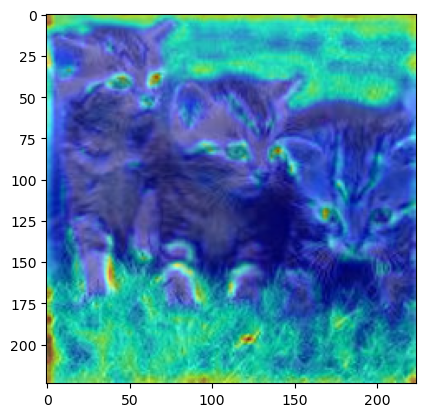

features_0
dog


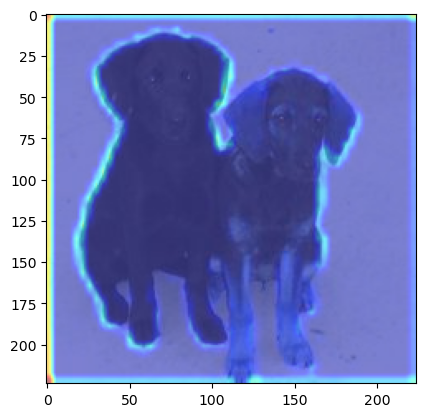

features_0
dog


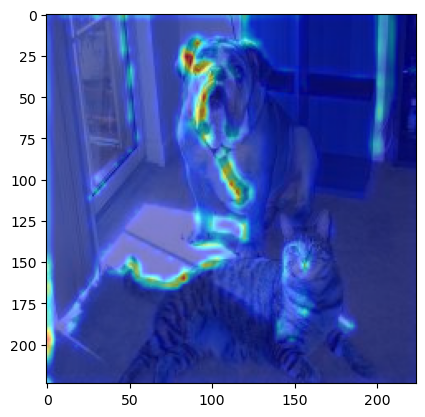

features_3
cat


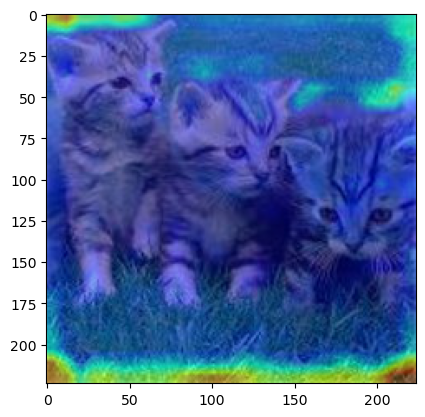

features_3
dog


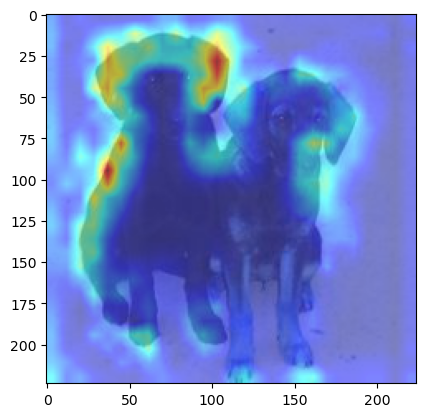

features_3
dog


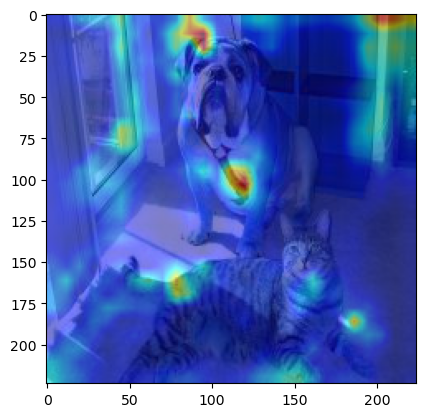

features_8
cat


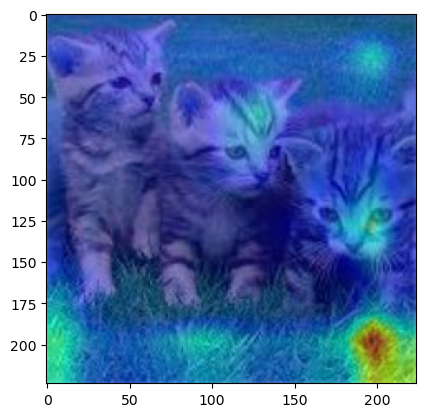

features_8
dog


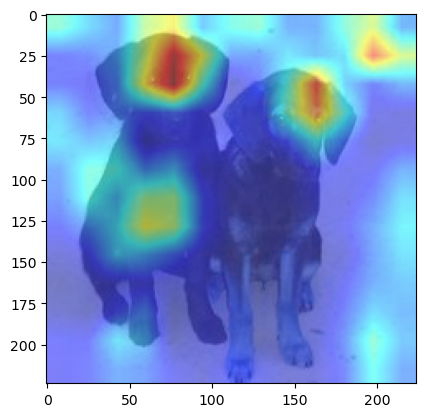

features_8
dog


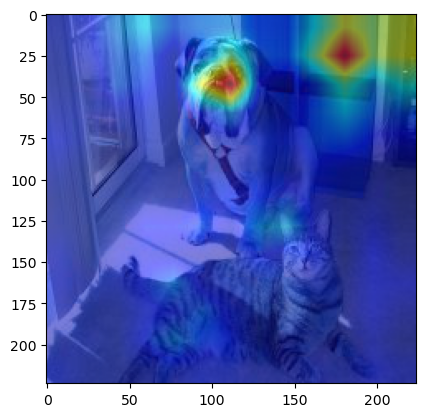

features_10
cat
activation map:


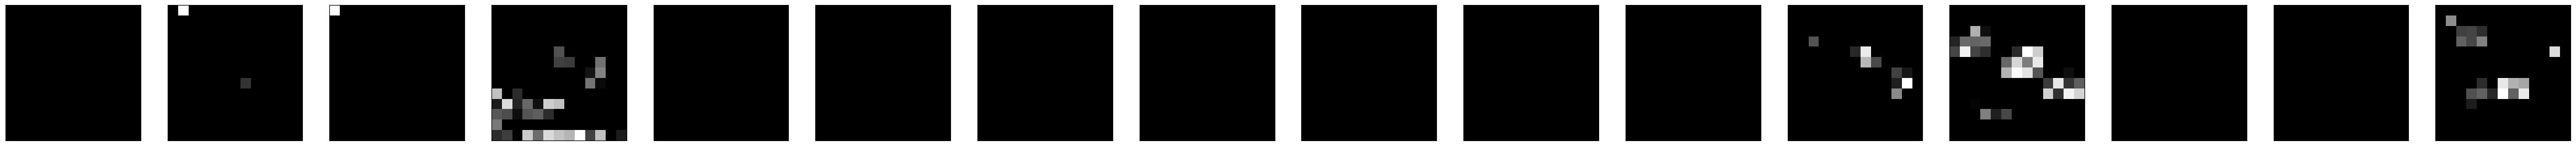

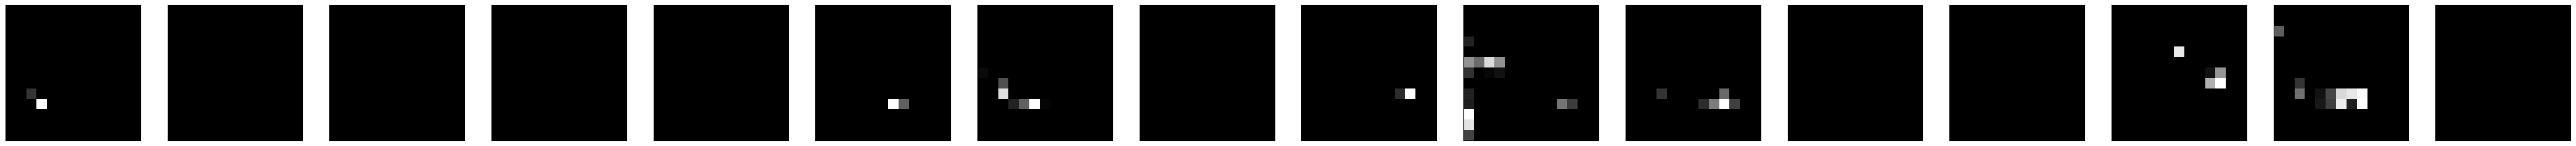

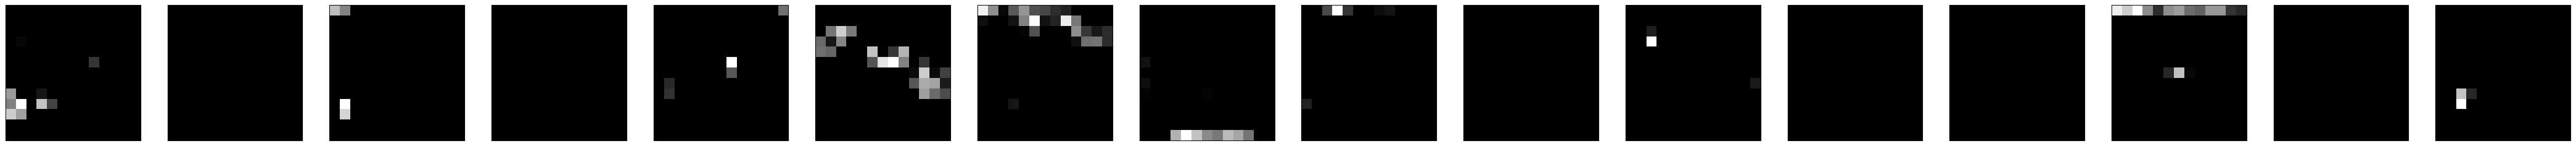

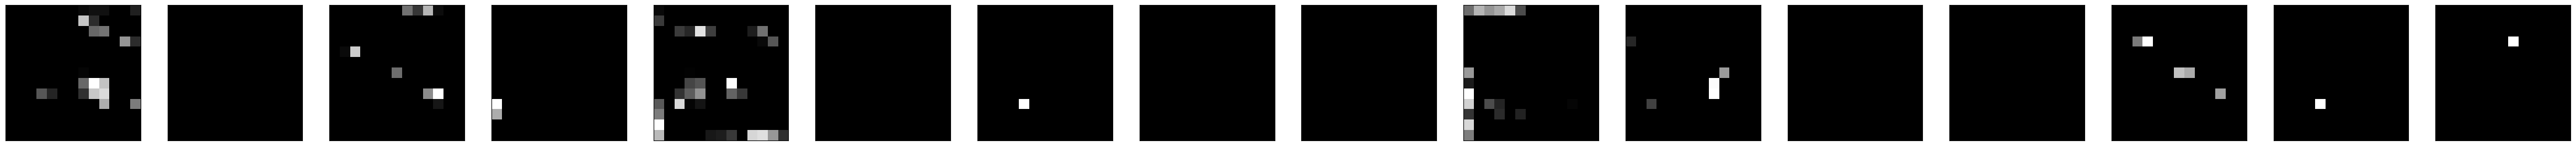

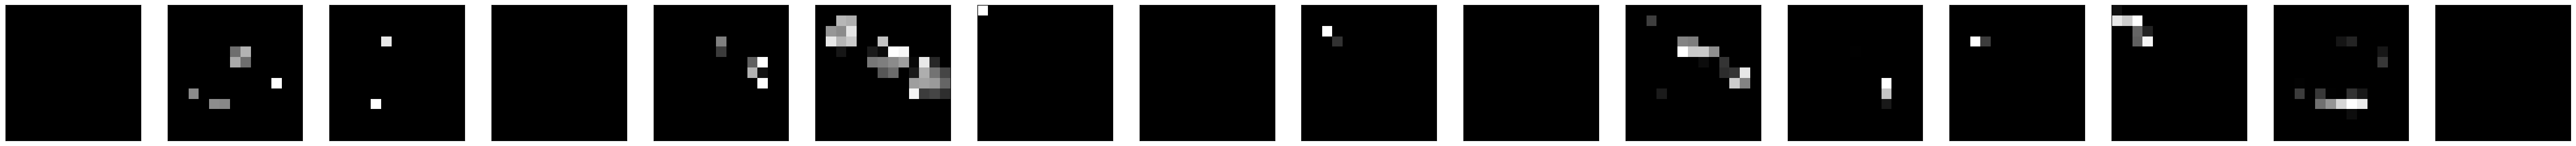

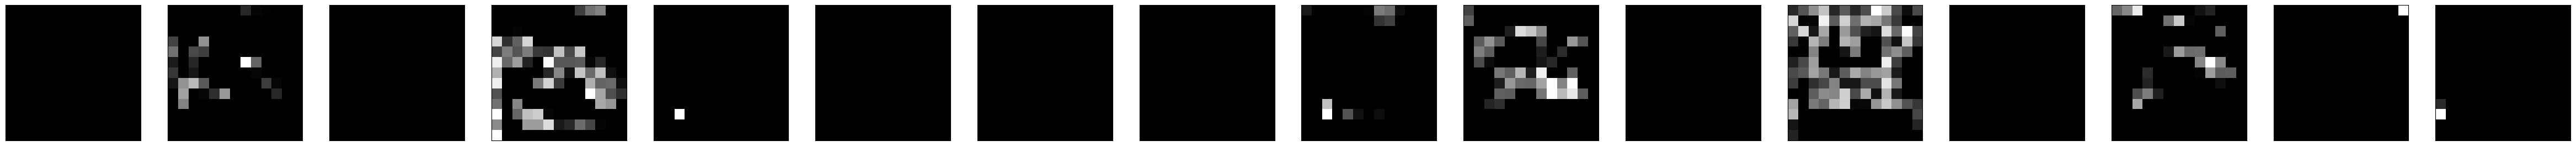

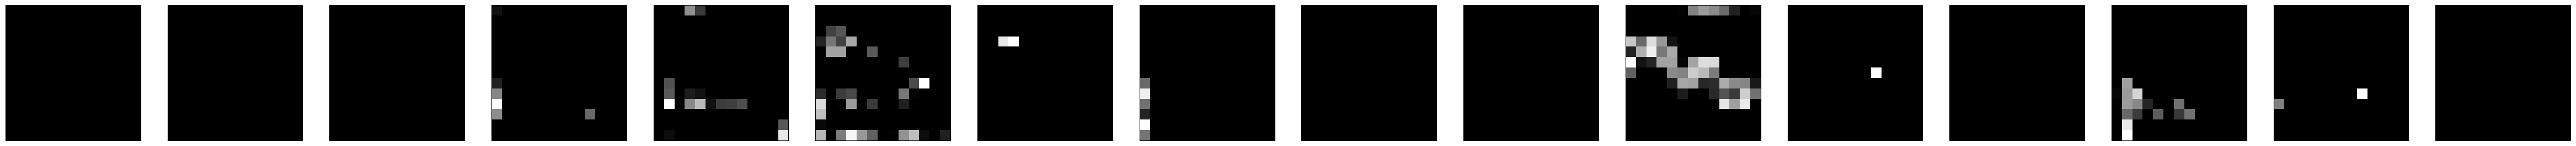

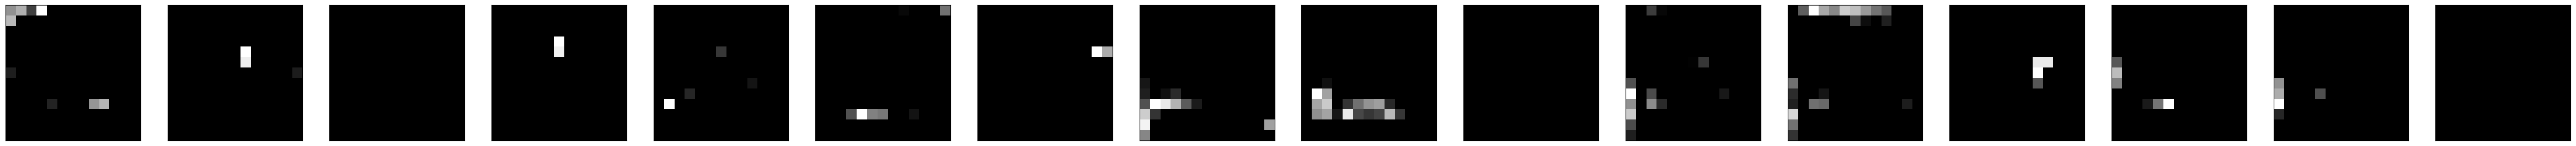

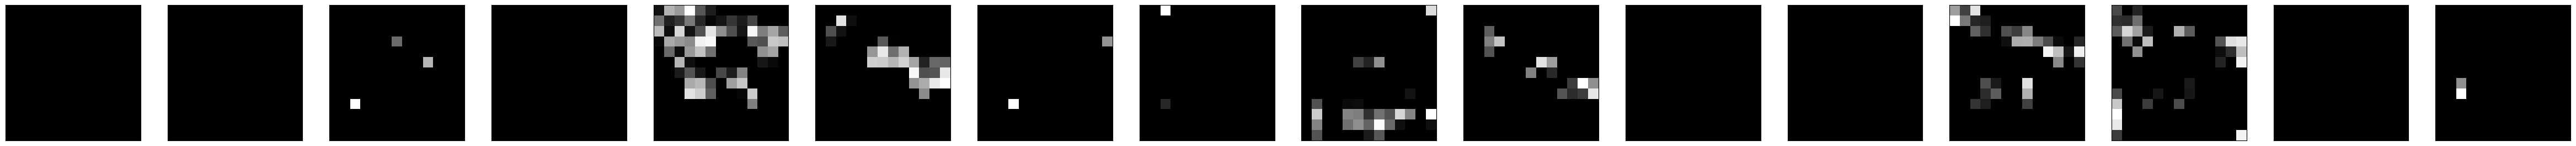

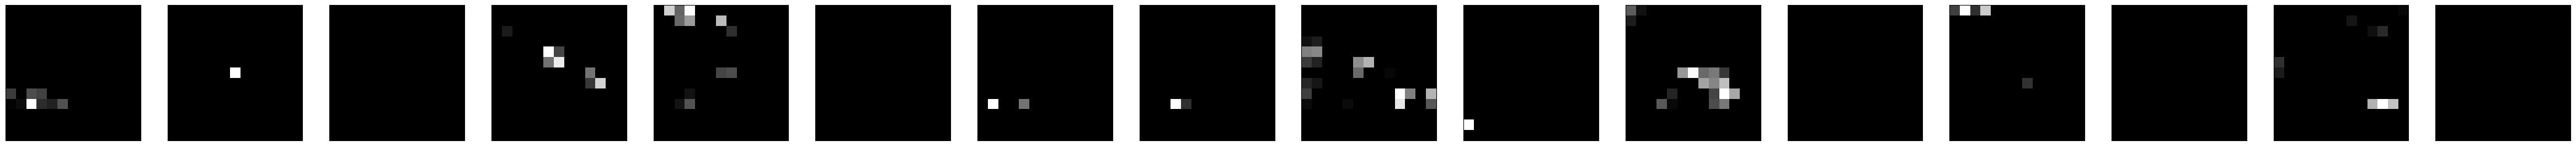

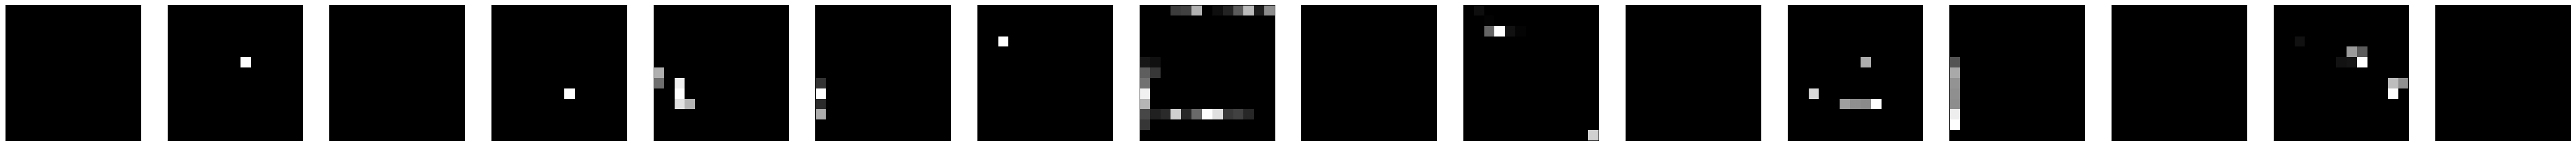

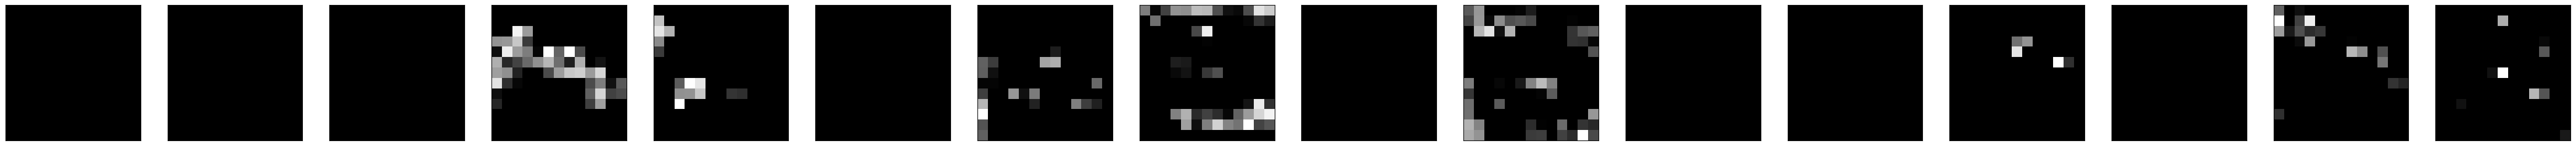

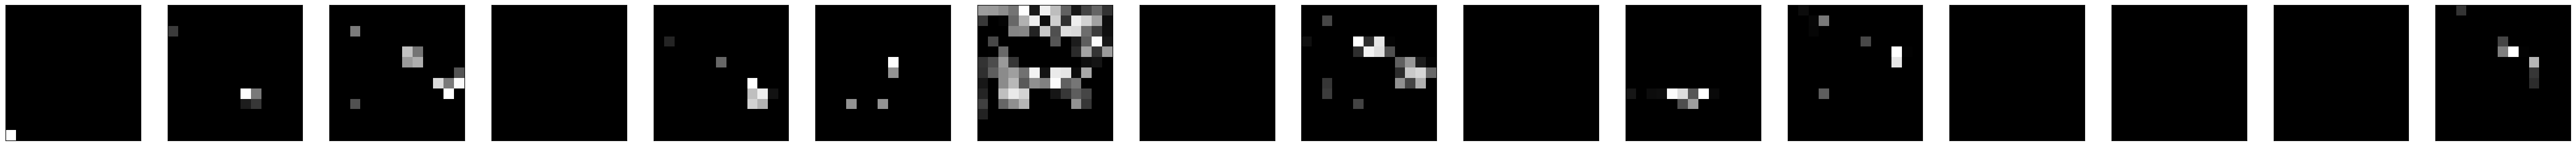

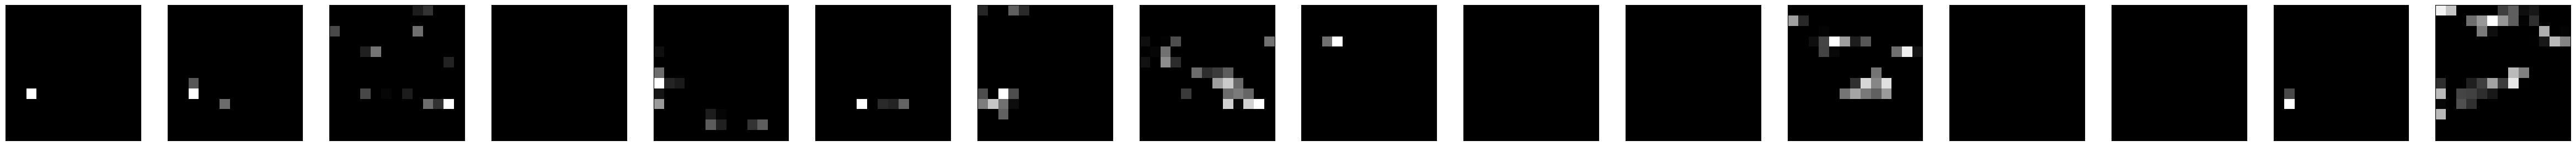

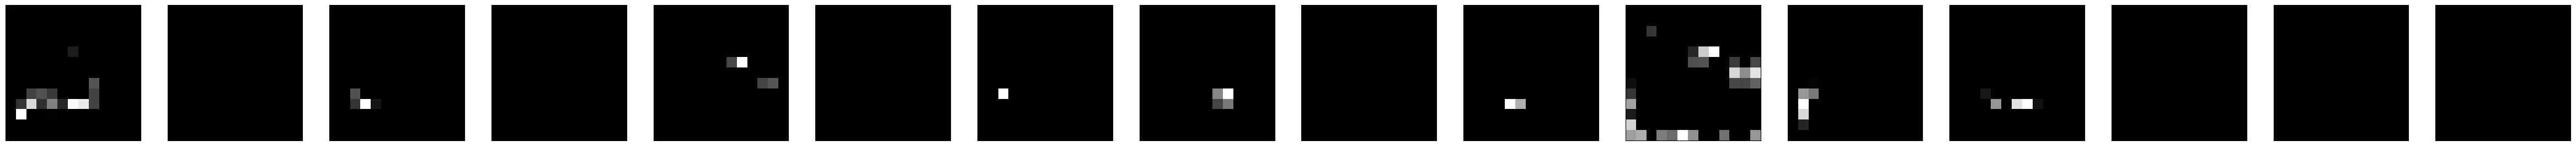

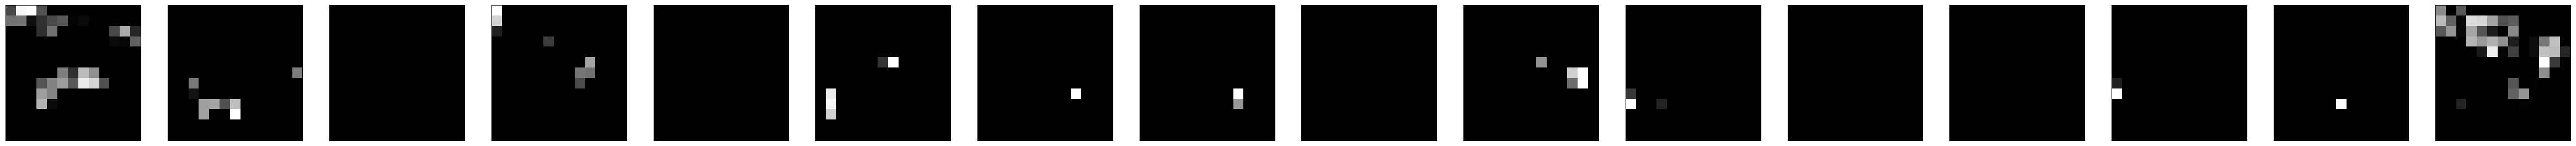

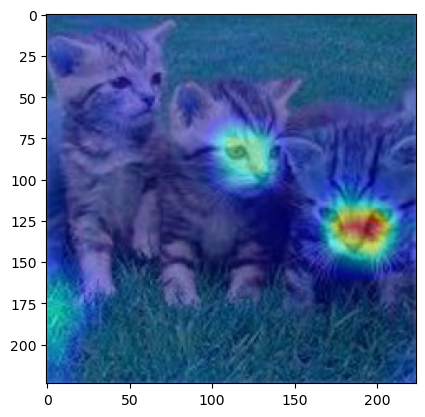

features_10
dog
activation map:


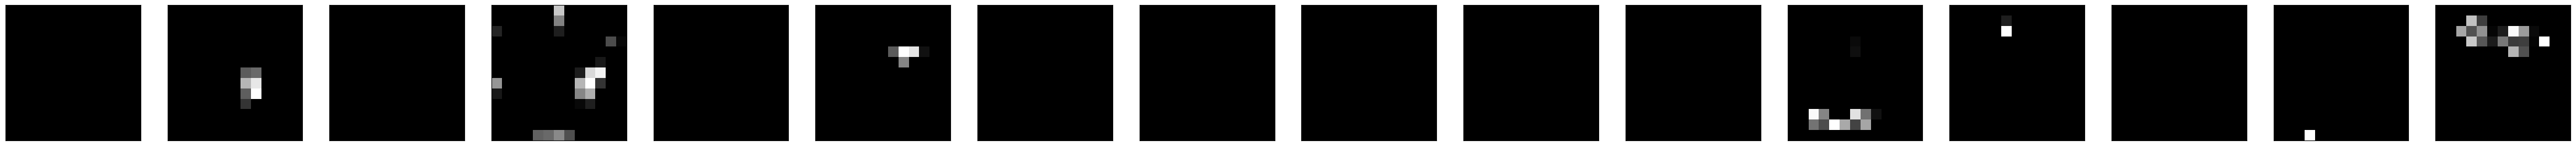

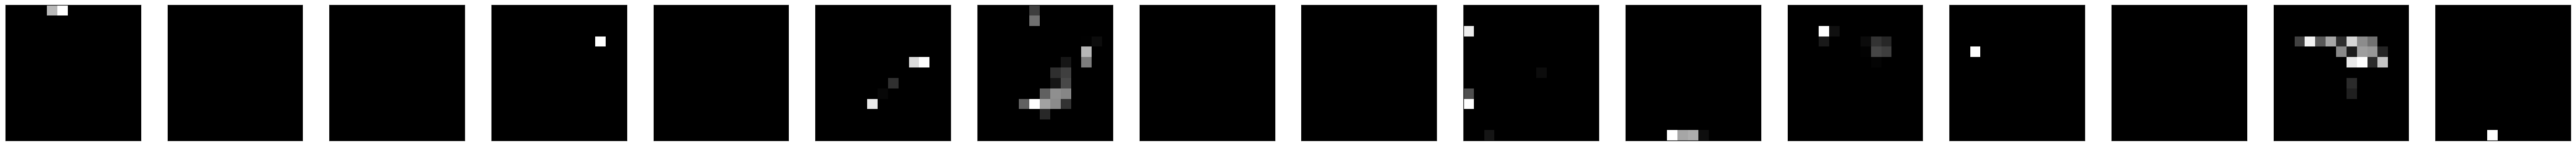

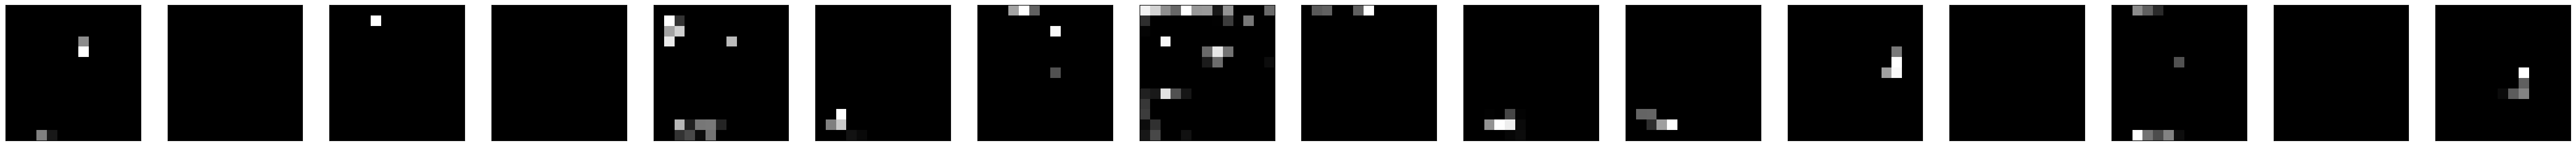

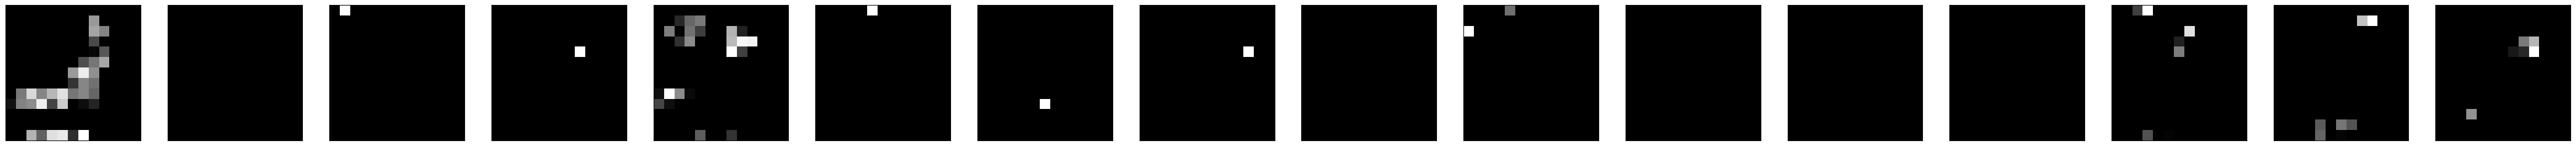

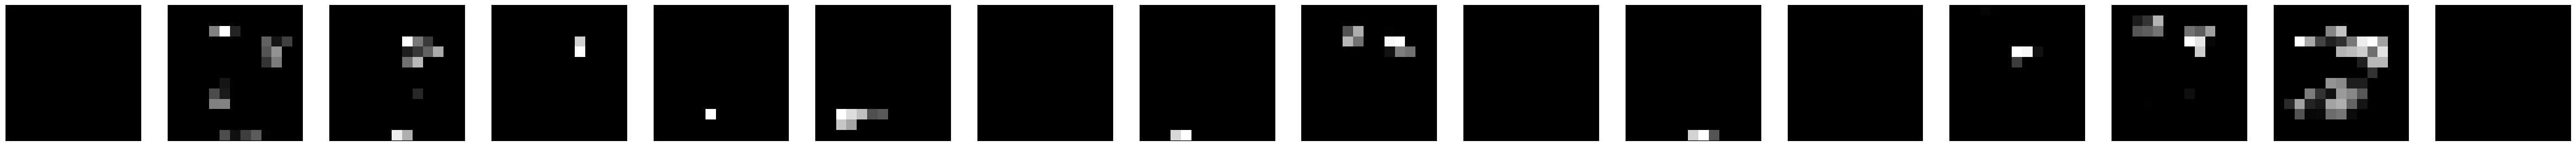

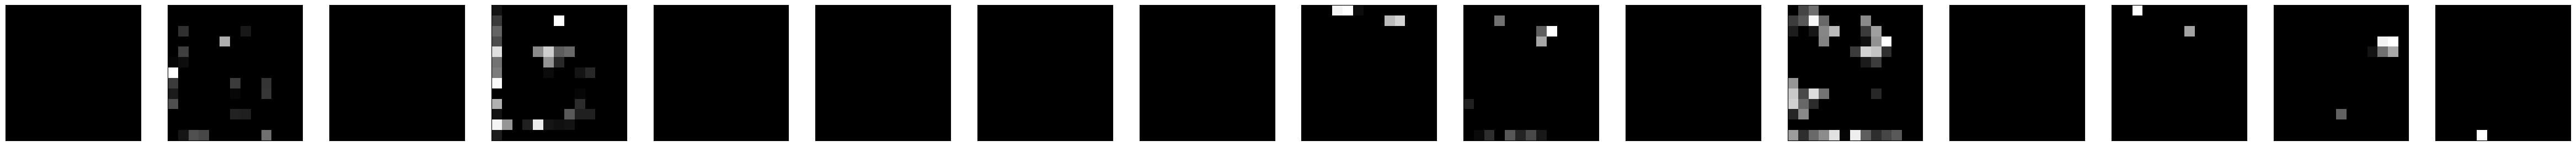

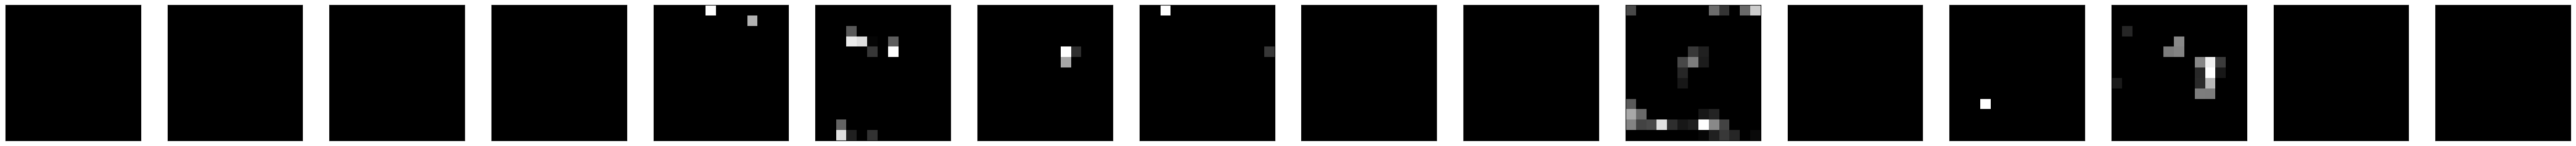

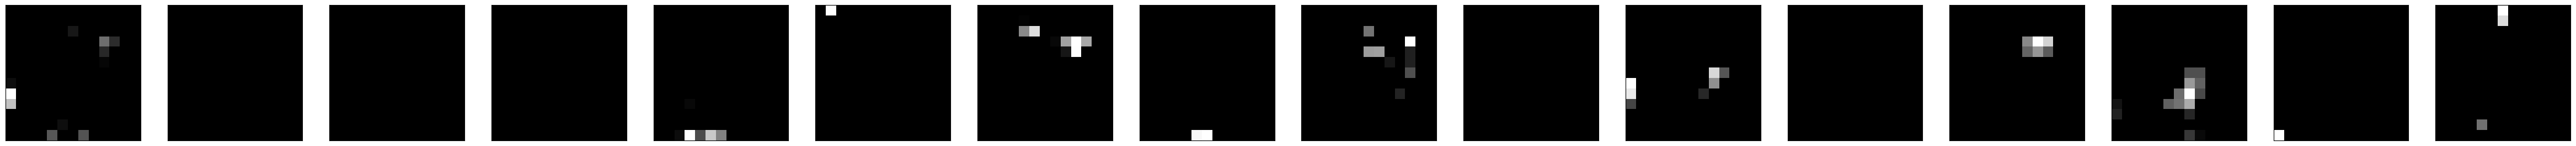

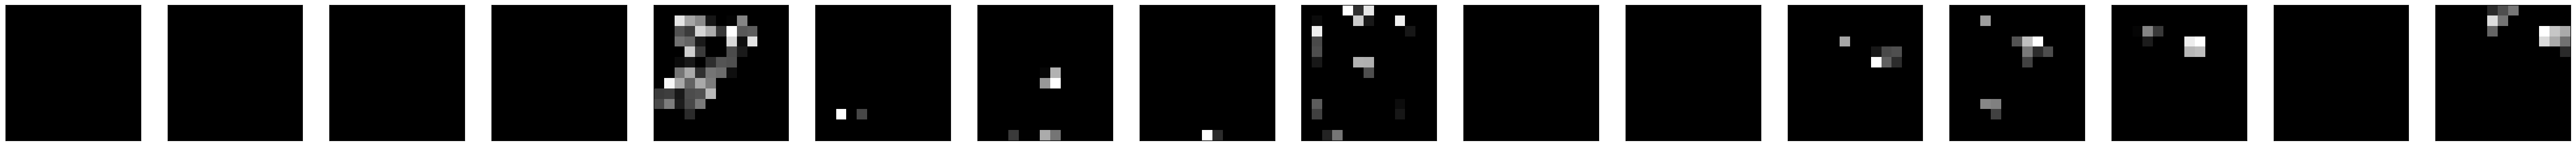

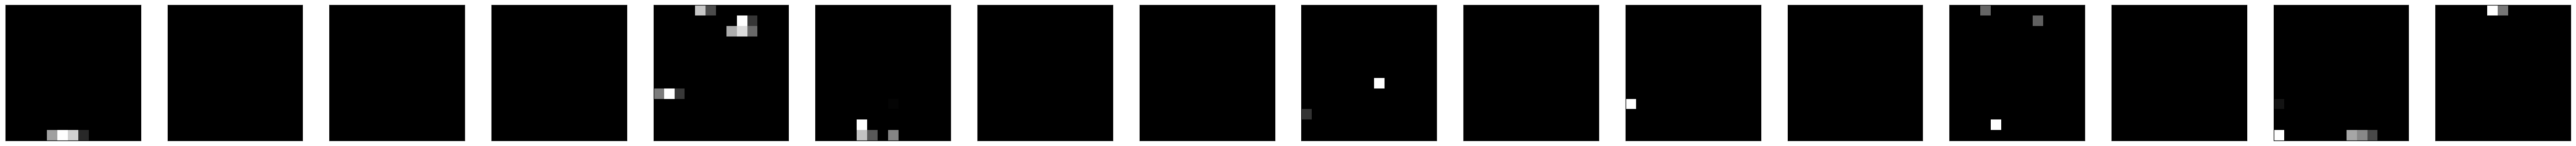

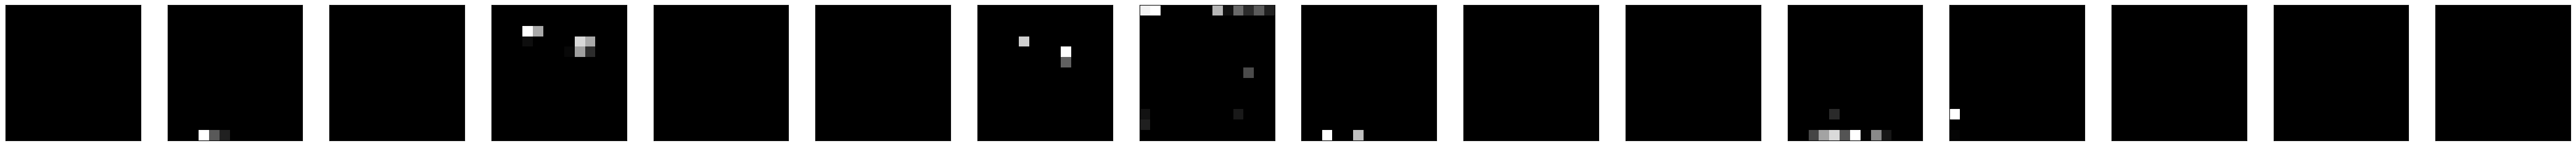

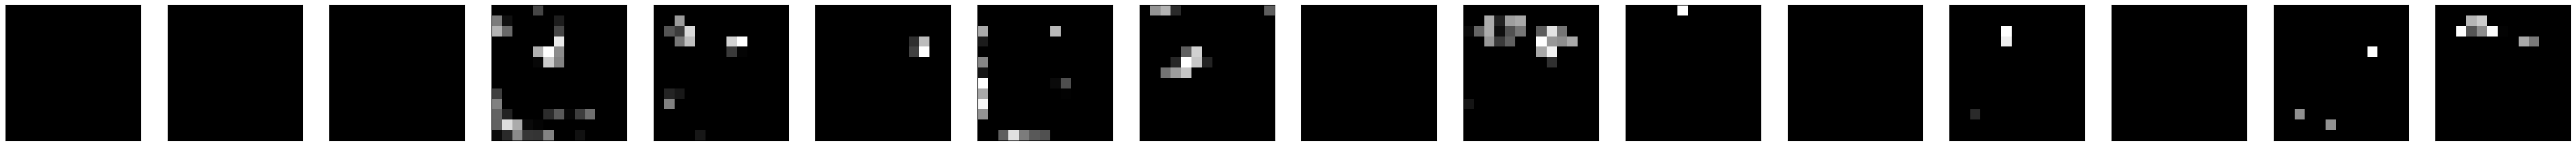

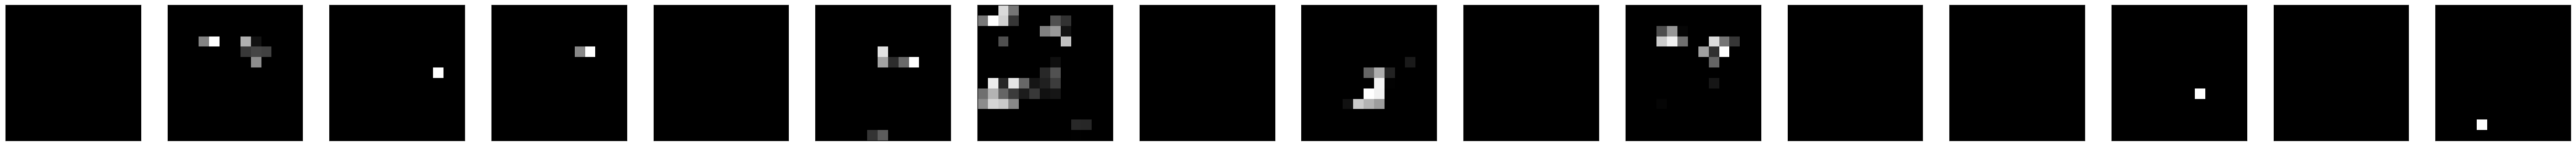

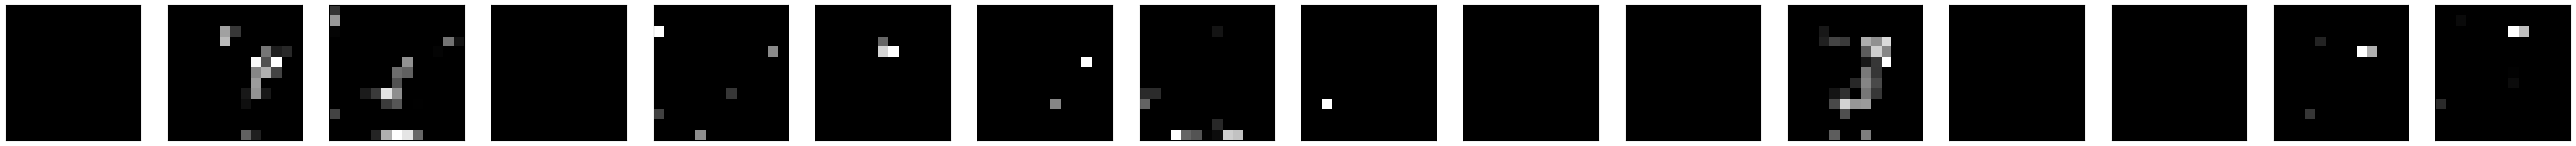

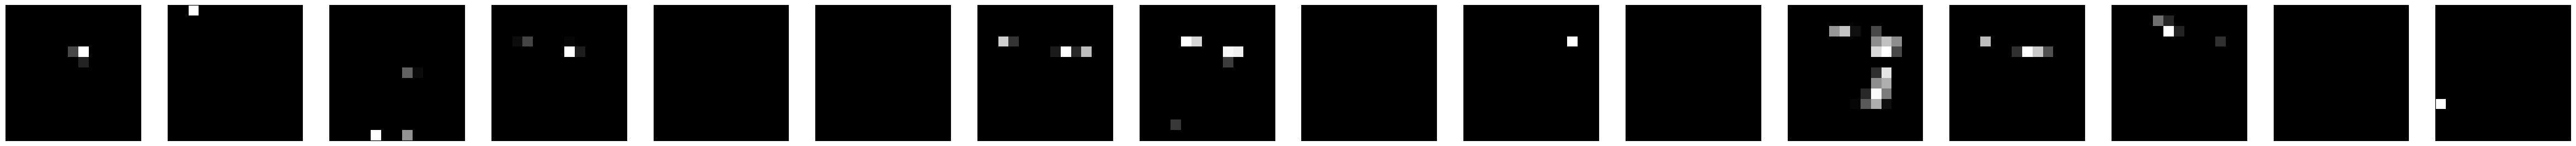

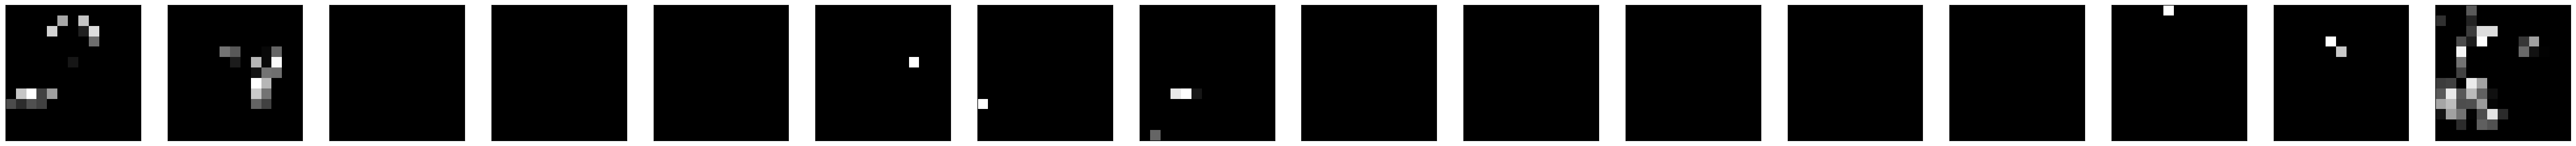

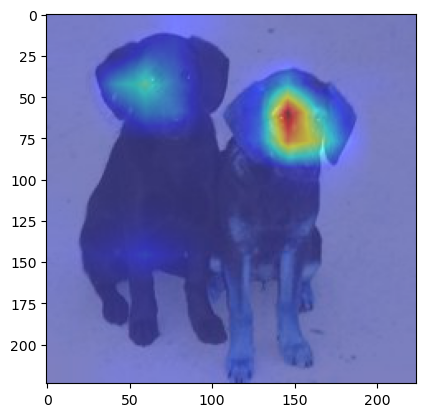

features_10
dog
activation map:


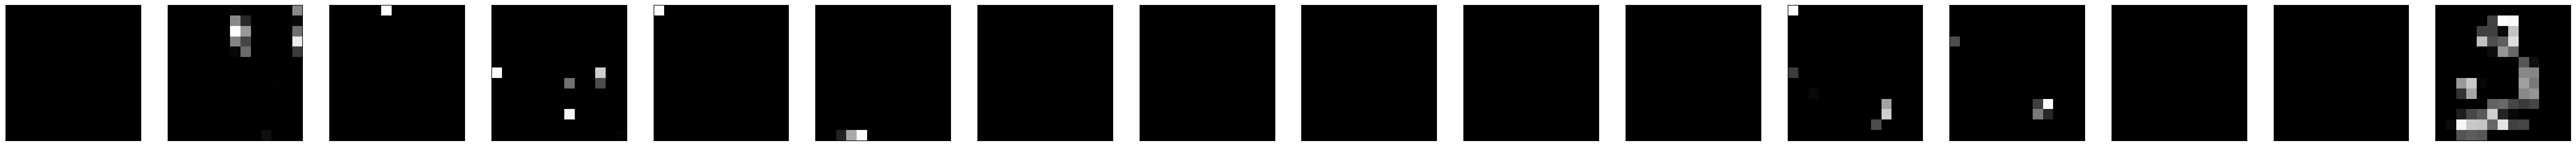

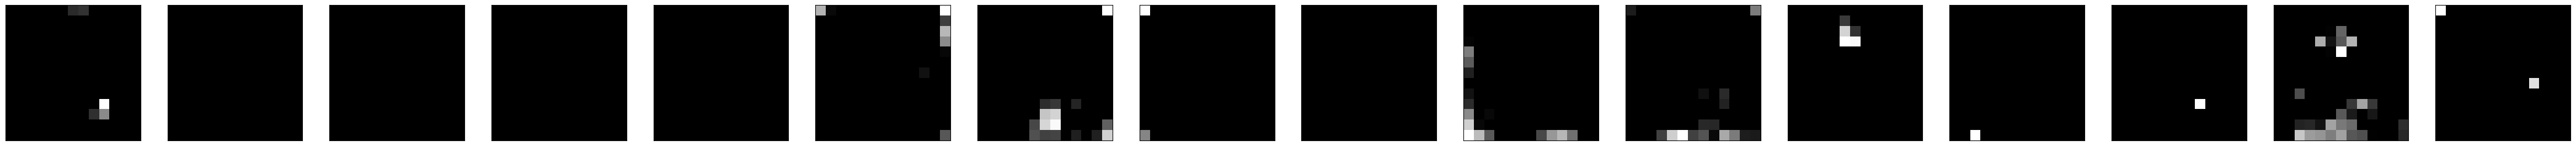

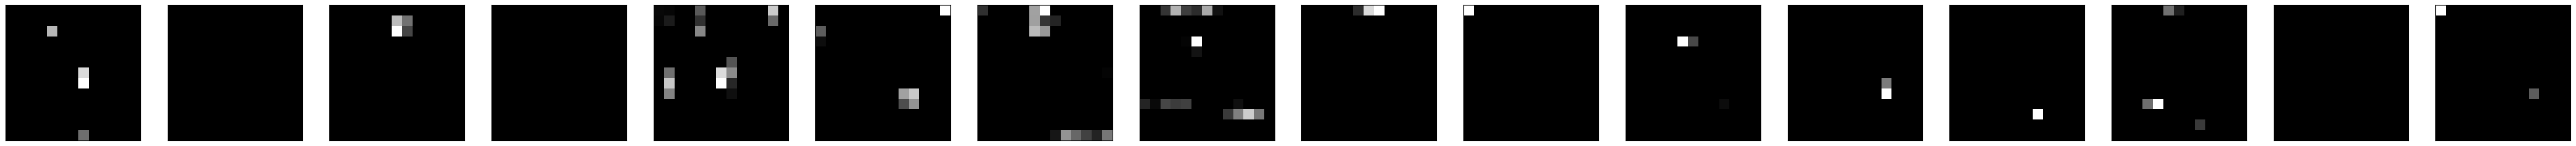

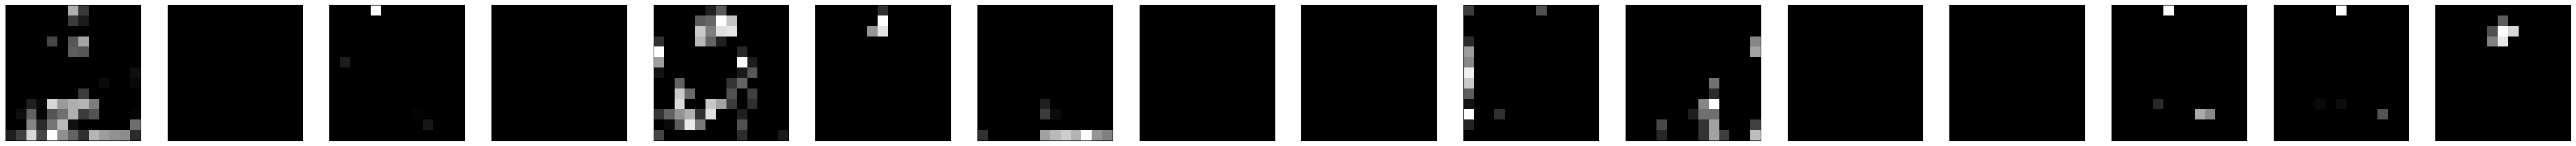

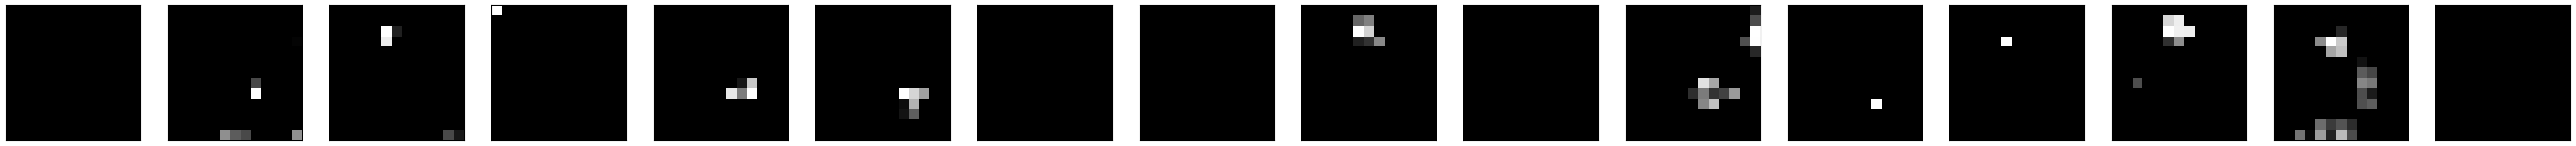

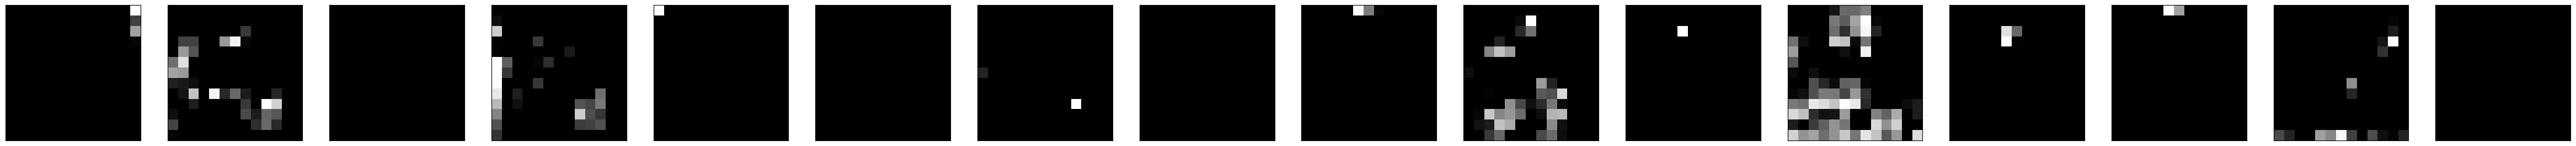

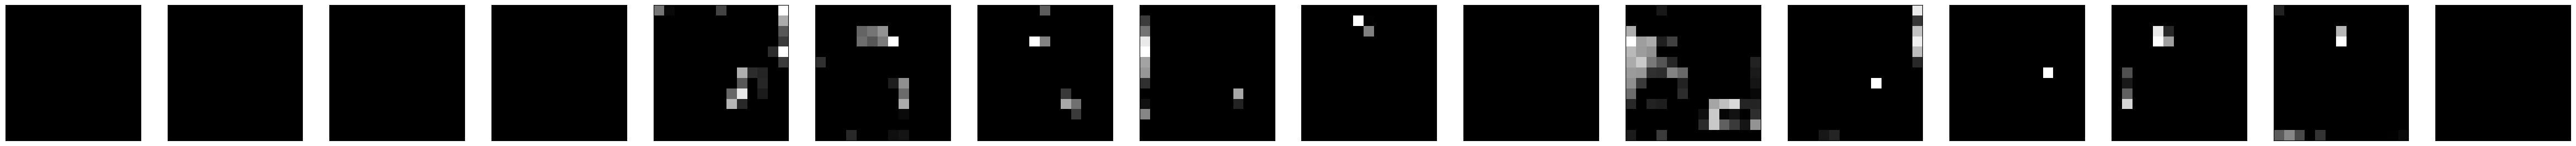

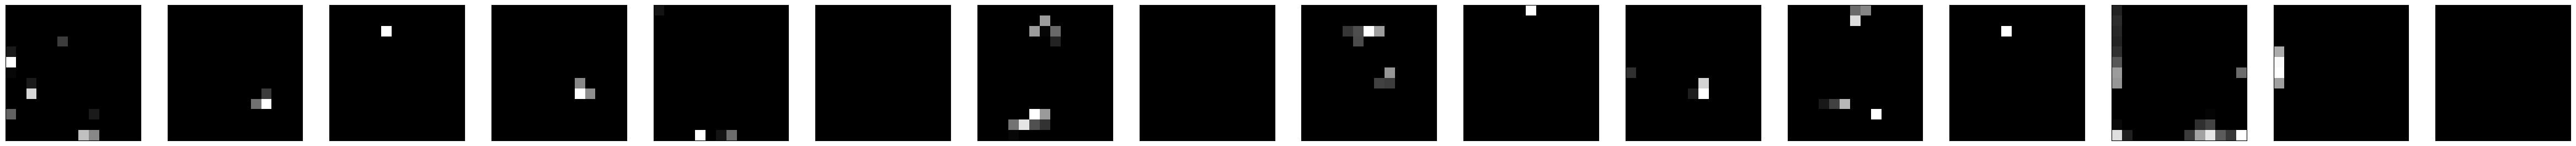

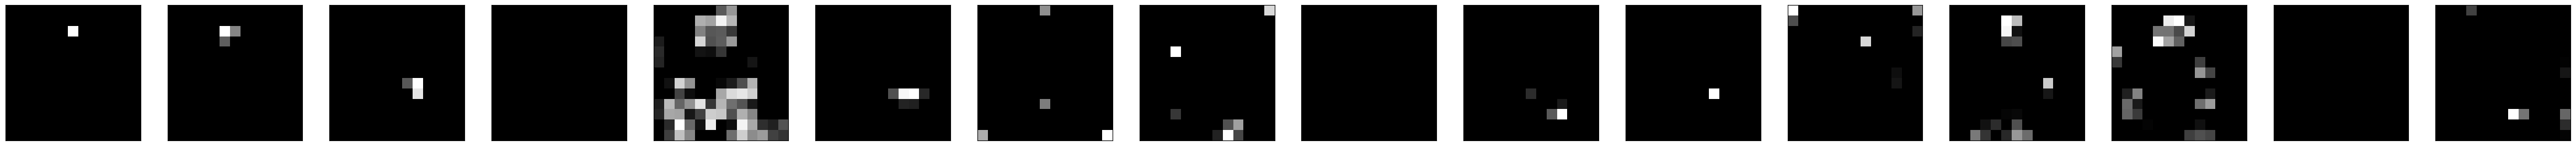

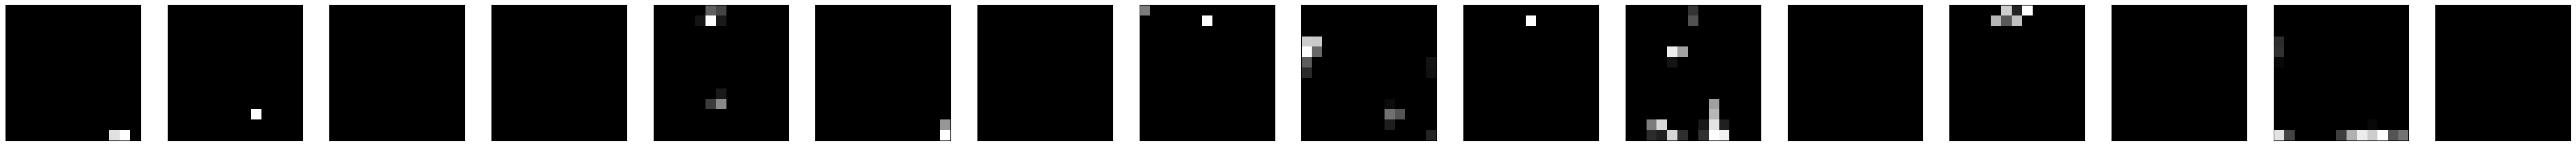

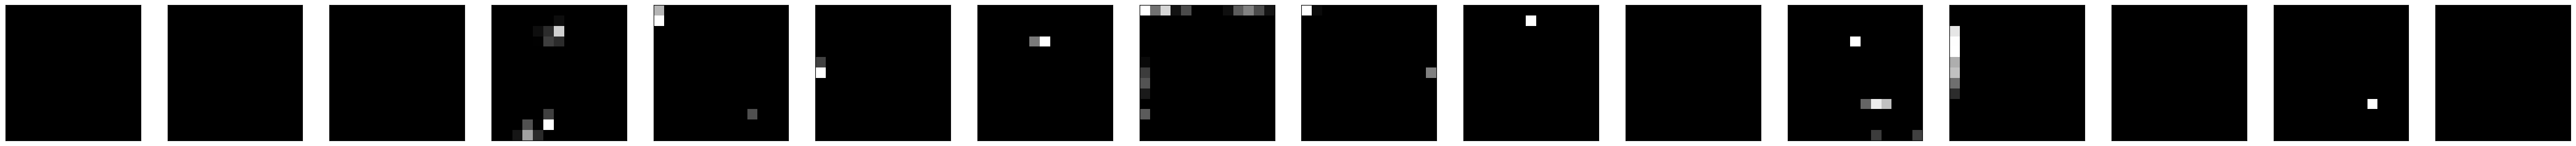

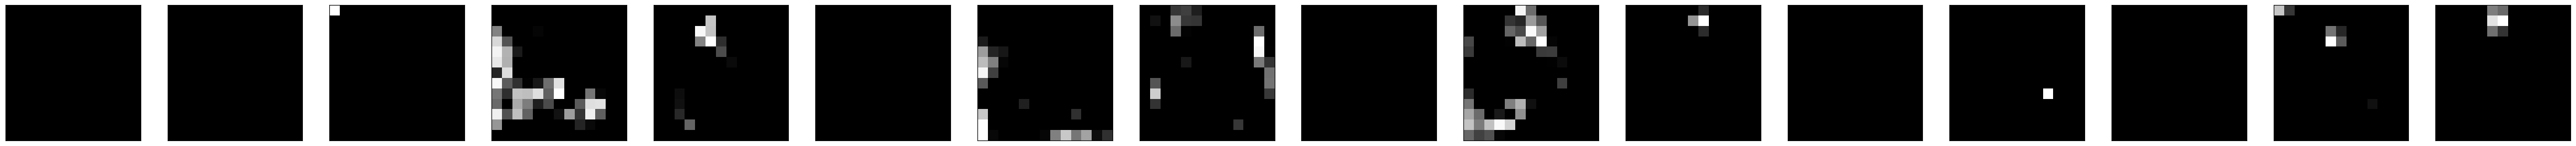

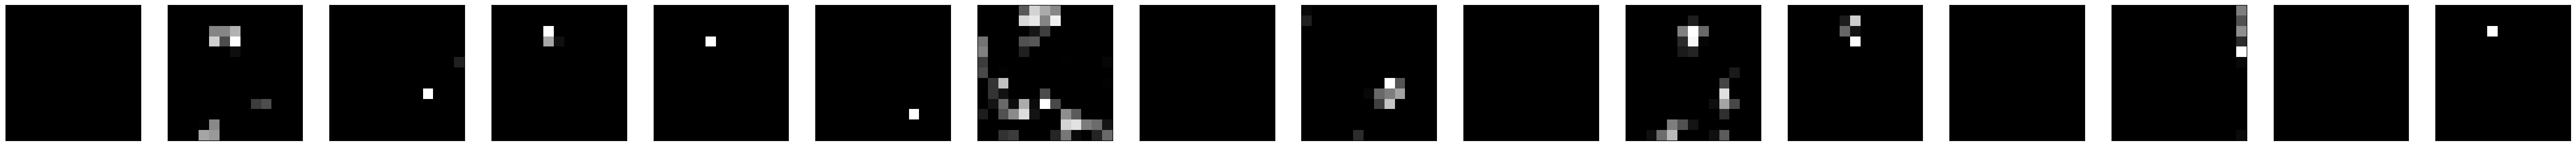

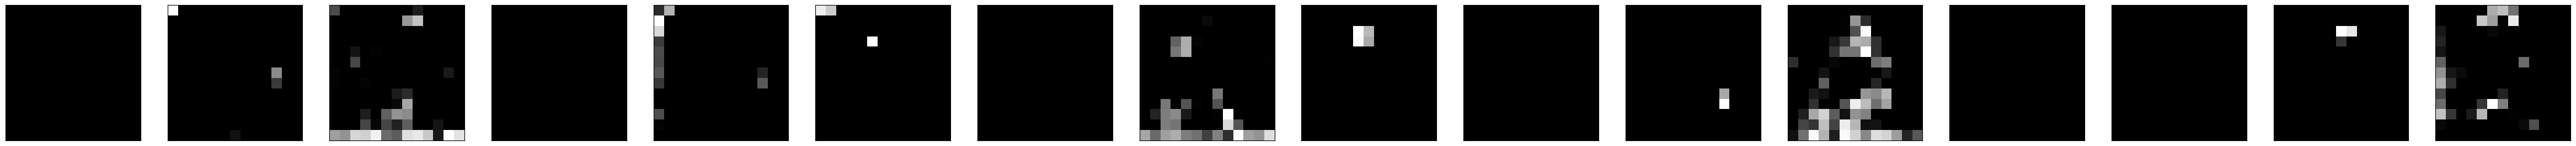

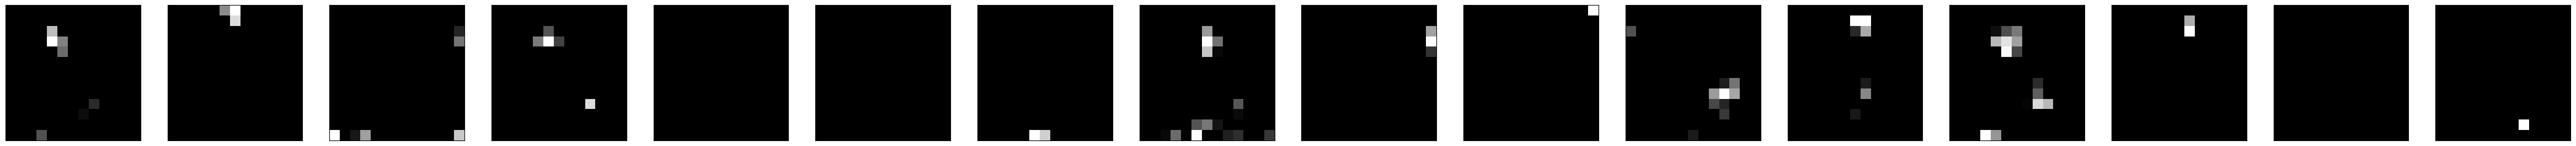

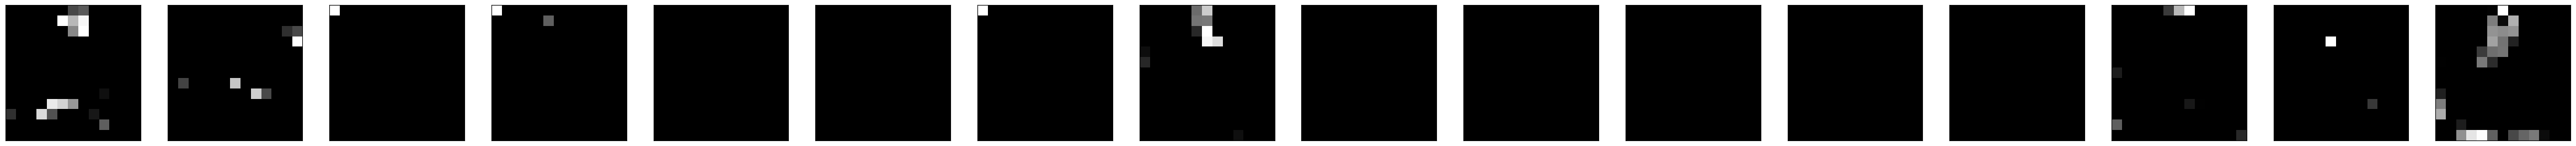

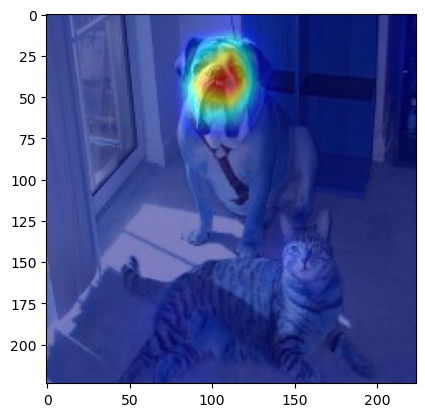

In [9]:
def cam_show_img(img, cam, activations):
    if activations is not None:
        print("activation map:")
        activations = activations[0]
        for i in range(activations.shape[0] // 16):
            plt.figure(figsize=(60, 4))
            for j in range(0, 16):
                ax = plt.subplot(1, 16, j + 1)
                ax.set_xticks([])
                ax.set_yticks([])
                activation_vis = np.uint8(255 * activations[i * 16 + j])
                plt.imshow(np.uint8(activation_vis), cmap='gray')
            plt.show()

    cam = cam[0]
    # print(cam.shape)
    (H, W, channel) = img.shape
    cam = cv2.resize(cam.transpose(1, 2, 0), (W, H))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    cam_img = 0.5 * heatmap + 0.5 * img

    plt.imshow(np.uint8(cam_img))
    plt.show()


for i in [0, 3, 8, 10]:
    for path in ["cat.jpg", "dog.jpg", "both.jpg"]:
        raw_img = cv2.imread("lab4_model_and_test_img/data4/" + path)
        preprocess = transforms.ToTensor()
        img = preprocess(raw_img)
        img = torch.unsqueeze(img, 0).cuda()

        model = torch.load('lab4_model_and_test_img/torch_alex.pth').cuda()
        layer_name = f'features_{i}'
        print(layer_name)
        layercam = LayerCAM(model, model.features[i])
        predicted = model(img).argmax()
        print("cat" if predicted == 0 else "dog")

        layercam_map, activations = layercam(img)
        # print(layercam_map.shape)
        cam_show_img(raw_img, layercam_map.cpu().numpy(), activations.cpu().numpy() if i == 10 else None)
        